In [2]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [3]:
import numpy as np
import pandas as pd
import datetime as dt

# Reflect Tables into SQLAlchemy ORM

In [4]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func

In [5]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [6]:
# reflect an existing database into a new model
Base = automap_base()
Base.prepare(autoload_with=engine)
Base.classes.keys()


['measurement', 'station']

In [7]:
# View all of the classes that automap found
print(Base.classes.keys())

['measurement', 'station']


In [18]:
# Save references to each table
measurement = Base.classes.measurement
station = Base.classes.station

In [9]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [15]:
from sqlalchemy import inspect,func
engine = inspect(engine)
columns = engine.get_columns('measurement')
for c in columns:
    print(c['name'], c["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [19]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()


('2017-08-23',)

In [22]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 

session.query(measurement.date).\
    filter (measurement.date>'2016-08-22').\
    order_by (measurement.date).all()

# Calculate the date one year from the last date in data set.
results_date=session.query(measurement.date).order_by(measurement.date.desc()).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)

# Perform a query to retrieve the data and precipitation scores
results=session.query(measurement.date, measurement.prcp).order_by(measurement.date.asc()).\
        filter(measurement.date>=year_back).all()


# Save the query results as a Pandas DataFrame. Explicitly set the column names
df_results=pd.DataFrame(results)
df_results=df_results.rename(columns={"prcp":"precipitation"})

# Sort the dataframe by date
df_results.sort_values(by=['date'], ascending=True)
df_results=df_results.dropna()
df_results=df_results.reset_index(drop=True)



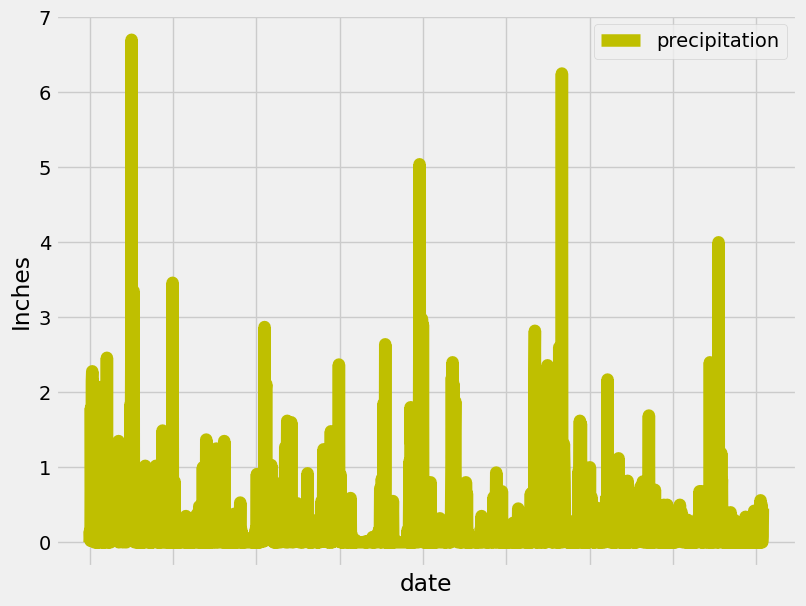

In [42]:
# Use Pandas Plotting with Matplotlib to plot the data

ax=df_results.plot(color='y',figsize=(8,6),legend=True,linewidth=9.0,grid=True)

plt.setp(ax.get_xticklabels(), visible=False)
plt.tight_layout()
plt.xlabel("date")
plt.ylabel("Inches")
plt.show()

In [45]:
# Use Pandas to calculate the summary statistics for the precipitation data

df_results.describe()

,date,precipitation
count,2021,2021.000000
mean,2017-02-16 08:55:06.086095872,0.177279
min,2016-08-23 00:00:00,0.000000
25%,2016-11-17 00:00:00,0.000000
50%,2017-02-14 00:00:00,0.020000
75%,2017-05-17 00:00:00,0.130000
max,2017-08-23 00:00:00,6.700000
std,NaN,0.461190


# Exploratory Station Analysis

In [46]:
# Design a query to calculate the total number of stations in the dataset
station_total=session.query(func.count(Station.id)).all()
station_total

[(9,)]

In [47]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.

station_count=session.query(measurement.station,func.count(measurement.station)).\
                       group_by(measurement.station).\
                       order_by(func.count(measurement.station).desc()).all()
station_count


[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [49]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.

results_overall=session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).\
             filter(measurement.station==station_count[0][0]).all()
results_overall

[(54.0, 85.0, 71.66378066378067)]

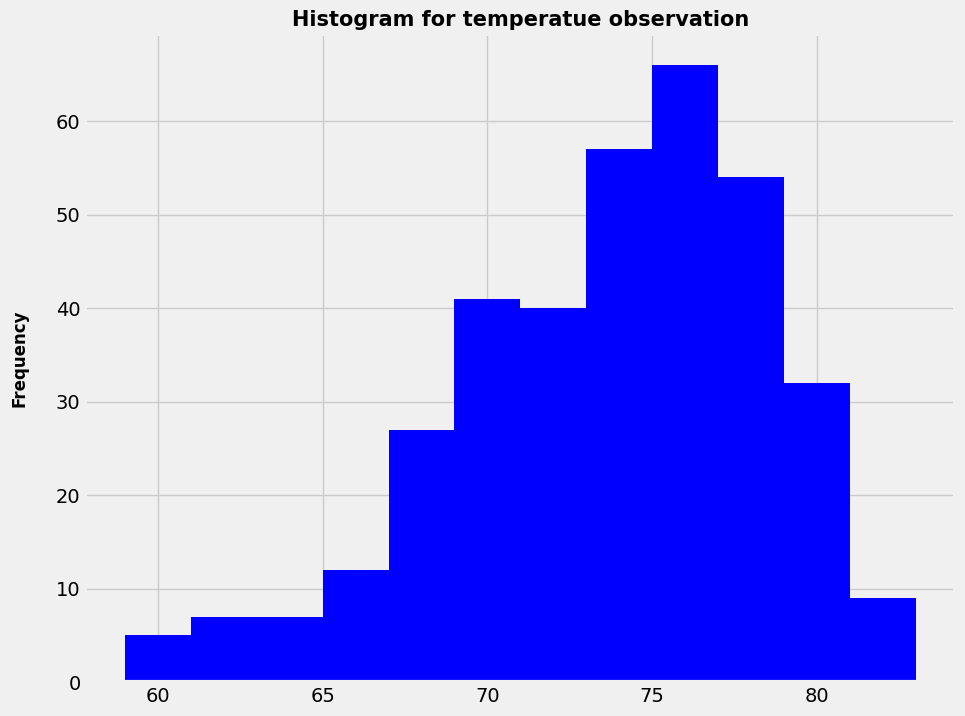

In [58]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
results_date=session.query(measurement.date).order_by(measurement.date.desc()).\
             filter(measurement.station==station_count[0][0]).first()
str_date=list(np.ravel(results_date))[0]
latest_date=dt.datetime.strptime(str_date,"%Y-%m-%d")
year_back=latest_date-dt.timedelta(days=366)

results_overall=session.query(measurement.tobs).\
             filter(measurement.station==station_count[0][0]).\
             filter(measurement.date>=year_back).all()
df_results=pd.DataFrame(results_overall)


hist = df_results['tobs'].hist(bins=12,figsize=(10,8), color='b', zorder=2)

hist.set_title("Histogram for temperatue observation",weight='bold', size=15)


hist.set_ylabel("Frequency", labelpad=20, weight='bold', size=12)

plt.show()

# Close Session

In [59]:
# Close Session
session.close()